
# Welcome

This notebook was generated by the eWaterCycle experiment launcher.

The notebook runs a hydrology model using [grpc4bmi](https://github.com/eWaterCycle/grpc4bmi).



In [19]:
from ewatercycle.parametersetdb import build_from_urls
import numpy as np
from grpc4bmi.bmi_client_docker import BmiClientDocker
import hydrostats.visual as hv
import matplotlib.pyplot as plt
import numpy
import numpy.ma as ma
import cftime
from bokeh.plotting import output_notebook, figure, show
import os
import pandas as pd

### Setting the input and output configuration

In [ ]:
parameter_set = build_from_urls(
    config_format='ini', config_url='https://raw.githubusercontent.com/UU-Hydro/PCR-GLOBWB_input_example/master/RhineMeuse30min/ini_and_batch_files/rapid/setup_natural_test.ini',
    datafiles_format='svn', datafiles_url='https://github.com/UU-Hydro/PCR-GLOBWB_input_example/trunk/RhineMeuse30min',
)
parameter_set.save_datafiles('./input')

The model inside a BMI Docker container expects the datafiles in the /data/input directory,
the config file must be adjusted to that. **Uncomment** the block of the model that you are using:

 - For **PCR-GLOBWB** model the input and output directory must be set with:

In [ ]:
parameter_set.config['globalOptions']['inputDir'] = '/data/input'
parameter_set.config['globalOptions']['outputDir'] = '/data/output'

- For **wflow** model the config file must be set with: 

In [ ]:
#parameter_set.config['model']['configfile'] = '/data/input/wflow_sbm.ini'
#replace config.cfg in the next cells with wflow_sbm.ini

- For **Walrus** model the data file must be set with

In [ ]:
#import os; parameter_set.config['data'] = '/data/input/' + os.listdir('input')[0]

Then it can be saved to the config file:

In [ ]:
parameter_set.save_config('config.cfg')

### Run docker container that contains model

In this example we use PCRGLOB

In [5]:
# Startup model
model = BmiClientDocker(image='ewatercycle/pcrg-grpc4bmi:latest', image_port=55555,
                        input_dir="./input",
                        output_dir="./output")
model.initialize('config.cfg')

In [6]:
# Evolve model and capture variable discharge at index 144 for each time step
variable = 'discharge'
index_of_variable = np.array([144])
variable_overtime = []
tend = model.get_end_time()
while model.get_current_time() < tend:
    model.update()
    value_at_pixel = model.get_value_at_indices(variable, index_of_variable)[0]
    variable_overtime.append((model.get_current_time(), value_at_pixel))


In [7]:
# Plot variable {0}
vals = model.get_value(variable)
unit = model.get_var_units(variable)
shape = model.get_grid_shape(model.get_var_grid(variable))

[]

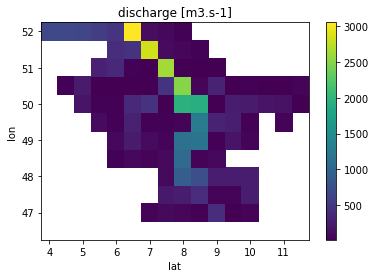

In [14]:
lon = model.get_grid_x(0)
lat = model.get_grid_y(0)
Z = numpy.reshape(ma.masked_where(vals == numpy.nan, vals), shape)
plt.title(r'{} [{}]'.format(variable,unit))
plt.pcolormesh(lat,lon,Z)
plt.colorbar()
plt.xlabel('lat')
plt.ylabel('lon')
plt.plot()


In [24]:
# Plot variable {0} at index {1} for each time step
output_notebook()

time_unit = model.get_time_units()
p = figure(plot_width=800, plot_height=400, x_axis_type="datetime")
p.yaxis.axis_label = variable + '[' + unit + ']'
p.line([cftime.num2date(d[0], time_unit) for d in variable_overtime], [d[1] for d in variable_overtime] , line_width=2)
show(p)

Loading BokehJS ...

In [12]:
print('model time step:', model.get_time_step())
print('model time unit:', model.get_time_units())
print('model time start:', model.get_start_time())
print('model time end:', model.get_end_time())

model time step: 1.0
model time unit: days since 1901-01-01
model time start: 36525.0
model time end: 40176.0


### Adjust the start/end time of your model to GRDC data.
Each modeler will have to adjust to his/her own model.

Here we adjust to pcrglob.

In [20]:
def dataframe_from_stationId(grdc_folder, station_id):
    ''' Search the grdc_folder for a file with name <station_id>.day,
    skip the header rows and return the dates and discharges in a dataframe'''
    
    filename = str(station_id) + "_Q_Day.Cmd"
    grdc_file = os.path.join(grdc_folder, filename)

    grdc_data = pd.read_csv(grdc_file, skiprows=40, delimiter=';')
    
    
    
    grdc_data = grdc_data.rename(columns={grdc_data.columns[0]: 'date', grdc_data.columns[1]:'empty', grdc_data.columns[2]: 'discharge'})
    
    grdc_data = grdc_data.reset_index().set_index(pd.DatetimeIndex(grdc_data['date']))
    grdc_data = grdc_data[['date', 'discharge']]
    
    return grdc_data

In [22]:
# Import GRDC station data, set index
obs = dataframe_from_stationId('./data_erase/', 6435060)
obs.set_index('date', inplace=True)